<a href="https://colab.research.google.com/github/alexeiveselov92/Yandex-Data-Analysis/blob/master/3.%20%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%BF%D0%B5%D1%80%D1%81%D0%BF%D0%B5%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D0%B3%D0%BE%20%D1%82%D0%B0%D1%80%D0%B8%D1%84%D0%B0%20%D0%B4%D0%BB%D1%8F%20%D1%82%D0%B5%D0%BB%D0%B5%D0%BA%D0%BE%D0%BC%20%D0%BA%D0%BE%D0%BC%D0%BF%D0%B0%D0%BD%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Откроем все доступные для анализа файлы

<font color='blue'> В начале полезно привести краткое описание проекта. </font>

Нам необходимо сравнить прибыльность, а также описать поведения пользователей по 2 тарифам.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
import copy

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

## Calls

In [0]:
#приведем даты к соотвествующему типу данных
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

#округлим значения времени звонков вверх
def ceil_value(value):
    return math.ceil(value)
calls['duration'] = calls['duration'].apply(ceil_value)   

#создадим доп столбец с месяцем
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

## Internet

In [0]:
#приведем даты к соотвествующему типу данных
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

#создадим доп столбец с месяцем
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

## Messages

In [0]:
#изменим тип данных в user_id - приведём его к int
messages['user_id'] = messages['user_id'].astype('int')

#приведем даты к соотвествующему типу данных
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

#создадим доп столбец с месяцем
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

## Users

In [0]:
#приведем даты в столбцах churn_date и reg_date к соответствующим форматам
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

#добавим информацию о тарифах в users в виде 0 и 1
def tariff_id(object):
    if object == 'smart':
        return 0
    elif object == 'ultra':
        return 1
users['tariff_id'] = users['tariff'].apply(tariff_id)

## Tariffs

In [0]:
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Расчёт средних значений 

In [0]:
#функция создания сводной таблицы - количества ресурсов по месяцам
def amount_by_month_func(data_in, values_column, func):
    data_out = data_in.pivot_table(index = 'user_id', values = values_column, columns = 'month', aggfunc = func)
    data_out.reset_index(inplace = True)
    return data_out

#создадим массивы с количествами израсходованных ресурсов по месяцам по всем пользователям в том числе и с кол-вом звонков
amount_of_minutes_by_month = amount_by_month_func(calls, 'duration', 'sum')
amount_of_messages_by_month = amount_by_month_func(messages, 'id', 'count')
amount_of_mbs_by_month = amount_by_month_func(internet, 'mb_used', 'sum')
number_of_minutes_by_month = amount_by_month_func(calls, 'duration', 'count')

#создадим словарь для отображения списка таблиц и функций, чтобы всегда можно было быстро его вывести
my_dict = {}
def to_dict(data, name):
    my_dict[name] = data

to_dict(amount_of_minutes_by_month, 'amount_of_minutes_by_month')
to_dict(amount_of_messages_by_month, 'amount_of_messages_by_month')
to_dict(amount_of_mbs_by_month, 'amount_of_mbs_by_month')
to_dict(number_of_minutes_by_month, 'number_of_minutes_by_month')
to_dict(amount_by_month_func, 'amount_by_month_func')

#напишем функцию добавления столбца в таблицу с 0 или 1 в зав-ти от тарифа
def add_tariff_id_func(data):
    data = data.merge(users[['user_id', 'tariff_id']], on='user_id', how='right')
    return data

to_dict(add_tariff_id_func, 'add_tariff_id_func')

#добавим столбец с номером тарифа в наши таблицы с количеством ресурсов 
amount_of_minutes_by_month = add_tariff_id_func(amount_of_minutes_by_month)
amount_of_messages_by_month = add_tariff_id_func(amount_of_messages_by_month)
amount_of_mbs_by_month = add_tariff_id_func(amount_of_mbs_by_month)
number_of_minutes_by_month = add_tariff_id_func(number_of_minutes_by_month)

In [0]:
#напишем функцию добавления необходимых данных о тарифе в зав-ти от tariff_id
def tariffs_info(row, info_column):
    result = tariffs[info_column][row['tariff_id']]
    return result
def add_tariffs_info_func(data, info_column):
    data[info_column] = data.apply(tariffs_info, axis = 1, args = [info_column])
    return data
to_dict(add_tariffs_info_func, 'add_tariffs_info_func')

In [0]:
#создадим таблицы, в которых будут расчитываться превышения лимитов по затраченным ресурсам
my_dict.keys()
minutes_over_limit = copy.deepcopy(amount_of_minutes_by_month)
messages_over_limit = copy.deepcopy(amount_of_messages_by_month)
mbs_over_limit = copy.deepcopy(amount_of_mbs_by_month)

to_dict(minutes_over_limit, 'minutes_over_limit')
to_dict(messages_over_limit, 'messages_over_limit')
to_dict(mbs_over_limit, 'mbs_over_limit')

#добавим столбцы с информацией о тарифах в будущие таблицы с превышениями 
add_tariffs_info_func(minutes_over_limit, 'minutes_included')
add_tariffs_info_func(messages_over_limit, 'messages_included')
add_tariffs_info_func(mbs_over_limit, 'mg_per_month_included')

#напишем функцию расчёта превышения лимитов
def over_limit(row, value_column, limit_column):
    result = float(row[value_column]) - float(row[limit_column])
    if result > 0:
        return result
    elif result <= 0:
        return 0
def to_over_limit_func(data, limit_column):
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        data[i] = data.apply(over_limit, axis = 1, args = [i, limit_column])
    return data

#перепишем количества израсходованных ресурсов на количества превышений лимитов
to_over_limit_func(minutes_over_limit, 'minutes_included')
to_over_limit_func(messages_over_limit, 'messages_included')
to_over_limit_func(mbs_over_limit, 'mg_per_month_included')

my_dict.keys()

dict_keys(['amount_of_minutes_by_month', 'amount_of_messages_by_month', 'amount_of_mbs_by_month', 'number_of_minutes_by_month', 'amount_by_month_func', 'add_tariff_id_func', 'add_tariffs_info_func', 'minutes_over_limit', 'messages_over_limit', 'mbs_over_limit'])

In [0]:
#создадим таблицы, в которых будут расчитываться прибыли, исходя из затраченных ресурсов
profit_per_minutes = copy.deepcopy(minutes_over_limit)
profit_per_messages = copy.deepcopy(messages_over_limit)
profit_per_mbs = copy.deepcopy(mbs_over_limit)
to_dict(profit_per_minutes, 'profit_per_minutes')
to_dict(profit_per_messages, 'profit_per_messages')
to_dict(profit_per_mbs, 'profit_per_mbs')

#добавим столбцы со стоимостями ресурсов в зав-ти от тарифа
add_tariffs_info_func(profit_per_minutes, 'rub_per_minute')
add_tariffs_info_func(profit_per_messages, 'rub_per_message')
add_tariffs_info_func(profit_per_mbs, 'rub_per_gb')

#функция расчёта прибыли за минуты по месяцам в строке
def profit_per_minutes_func(row, value_column):
    result = row[value_column] * row['rub_per_minute']
    return result

#функция расчёта прибыли за сообщения по месяцам в строке
def profit_per_messages_func(row, value_column):
    result = row[value_column] * row['rub_per_message']
    return result

#функция расчёта прибыли за интернет по месяцам в строке
def profit_per_mbs_func(row, value_column):
    try:
        result = math.ceil(row[value_column] / 1024) * row['rub_per_gb']
        return result
    except:
        return row[value_column]

#функция расчёта прибыли в массиве
def profit_func(data, func):
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        data[i] = data.apply(func, axis = 1, args = [i])
    return data

to_dict(profit_func, 'profit_func')

#рассчитаем прибыль в наших массивах
profit_func(profit_per_minutes, profit_per_minutes_func)
profit_func(profit_per_messages, profit_per_messages_func)
profit_func(profit_per_mbs, profit_per_mbs_func)
my_dict.keys()

dict_keys(['amount_of_minutes_by_month', 'amount_of_messages_by_month', 'amount_of_mbs_by_month', 'number_of_minutes_by_month', 'amount_by_month_func', 'add_tariff_id_func', 'add_tariffs_info_func', 'minutes_over_limit', 'messages_over_limit', 'mbs_over_limit', 'profit_per_minutes', 'profit_per_messages', 'profit_per_mbs', 'profit_func'])

In [0]:
#напишем функцию расчёта среднего значения за 12 месяцев
def mean_per_year(row):
    mean = row[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].mean()
    return mean

#напишем функцию добавления столбца со средними по году значениями
def add_mean_per_year_func(data, column_name):
    data[column_name] = data.apply(mean_per_year, axis = 1)
    return data

to_dict(add_mean_per_year_func, 'add_mean_per_year_func')

#добавим средние по году значения в доп. столбцы в необходимых нам массивах 
add_mean_per_year_func(amount_of_minutes_by_month, 'mean_duration')
add_mean_per_year_func(amount_of_messages_by_month, 'mean_messages')
add_mean_per_year_func(amount_of_mbs_by_month, 'mean_mbs')
add_mean_per_year_func(number_of_minutes_by_month, 'mean_calls')
add_mean_per_year_func(minutes_over_limit, 'mean_minutes_over_limit')
add_mean_per_year_func(messages_over_limit, 'mean_messages_over_limit')
add_mean_per_year_func(mbs_over_limit, 'mean_mbs_over_limit')
add_mean_per_year_func(profit_per_minutes, 'mean_profit_per_minutes')
add_mean_per_year_func(profit_per_messages, 'mean_profit_per_messages')
add_mean_per_year_func(profit_per_mbs, 'mean_profit_per_mbs')
my_dict.keys()


dict_keys(['amount_of_minutes_by_month', 'amount_of_messages_by_month', 'amount_of_mbs_by_month', 'number_of_minutes_by_month', 'amount_by_month_func', 'add_tariff_id_func', 'add_tariffs_info_func', 'minutes_over_limit', 'messages_over_limit', 'mbs_over_limit', 'profit_per_minutes', 'profit_per_messages', 'profit_per_mbs', 'profit_func', 'add_mean_per_year_func'])

In [0]:
#объединим все необходимые нам столбцы в один массив
amount_of_minutes_by_month
#функция объединения выбранных столбцов из таблиц
def merger_func(data1, data2, list_columns_data2):
    list_columns_data2.insert(0, 'user_id')
    df = data1.merge(data2[list_columns_data2], on='user_id', how='right')
    return df
to_dict(merger_func, 'merger_func')

#создадим генеральную таблицу и добавим туда все необходимые столбцы
general_table = merger_func(amount_of_minutes_by_month[['user_id', 'tariff_id', 'mean_duration']], amount_of_messages_by_month, ['mean_messages'])
general_table = merger_func(general_table, amount_of_mbs_by_month, ['mean_mbs'])
general_table = merger_func(general_table, number_of_minutes_by_month, ['mean_calls'])
general_table = merger_func(general_table, minutes_over_limit, ['mean_minutes_over_limit'])
general_table = merger_func(general_table, messages_over_limit, ['mean_messages_over_limit'])
general_table = merger_func(general_table, mbs_over_limit, ['mean_mbs_over_limit'])
general_table = merger_func(general_table, profit_per_minutes, ['mean_profit_per_minutes'])
general_table = merger_func(general_table, profit_per_messages, ['mean_profit_per_messages'])
general_table = merger_func(general_table, profit_per_mbs, ['mean_profit_per_mbs'])
general_table = merger_func(general_table, users, ['city'])
general_table.columns

to_dict(general_table, 'general_table')

#поменяем порядок столбцов
general_table = general_table[['user_id', 'tariff_id', 'city', 'mean_calls', 'mean_duration', 'mean_minutes_over_limit', 
       'mean_profit_per_minutes', 'mean_messages', 'mean_messages_over_limit', 'mean_profit_per_messages', 'mean_mbs',
       'mean_mbs_over_limit', 'mean_profit_per_mbs']]
#добавим столбец с минимальной стоимостью тарифа
add_tariffs_info_func(general_table, 'rub_monthly_fee')

#посчитаем среднюю прибыль по клиентам
def mean_profit_func(row):
    result = row[['mean_profit_per_minutes', 'mean_profit_per_messages', 'mean_profit_per_mbs', 'rub_monthly_fee']].sum()
    return result
general_table['mean_profit'] = general_table.apply(mean_profit_func, axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
#создадим две таблицы по тарифам
smart = general_table[general_table['tariff_id'] == 0]
ultra = general_table[general_table['tariff_id'] == 1]

## Опишем поведение пользователей разных тарифов

In [0]:
smart[['mean_duration', 'mean_messages', 'mean_mbs', 'mean_minutes_over_limit', 
      'mean_messages_over_limit', 'mean_mbs_over_limit', 'mean_profit']].describe()

,mean_duration,mean_messages,mean_mbs,mean_minutes_over_limit,mean_messages_over_limit,mean_mbs_over_limit,mean_profit
count,349.000000,302.000000,350.000000,349.000000,302.000000,350.000000,351.000000
mean,420.840147,37.575606,16190.427408,45.871620,6.814128,2864.037178,1322.451159
std,143.473707,24.849738,3577.215353,70.179829,13.027865,2629.552917,606.464517
min,12.363636,1.000000,5384.218182,0.000000,0.000000,0.000000,550.000000
25%,317.545455,19.000000,13947.652500,0.000000,0.000000,653.388194,865.476190
50%,425.250000,33.000000,16267.380000,12.000000,0.000000,2216.865000,1176.400000
75%,520.400000,54.000000,18595.710972,67.000000,7.375000,4437.713786,1667.166667
max,891.500000,118.000000,27286.960000,467.500000,72.375000,14699.520000,4333.333333


In [0]:
ultra[['mean_duration', 'mean_messages', 'mean_mbs', 'mean_minutes_over_limit', 
      'mean_messages_over_limit', 'mean_mbs_over_limit', 'mean_profit']].describe()

,mean_duration,mean_messages,mean_mbs,mean_minutes_over_limit,mean_messages_over_limit,mean_mbs_over_limit,mean_profit
count,143.000000,124.000000,147.000000,143.0,124.0,147.000000,149.000000
mean,546.685442,64.555802,19726.550619,0.0,0.0,862.925653,2085.548788
std,268.338363,43.390612,8170.823338,0.0,0.0,1913.302600,297.732421
min,9.428571,3.000000,2301.760000,0.0,0.0,0.000000,1950.000000
25%,342.883333,28.000000,14806.842000,0.0,0.0,0.000000,1950.000000
50%,525.500000,57.800000,18829.486667,0.0,0.0,0.000000,1950.000000
75%,750.000000,89.000000,25964.860000,0.0,0.0,175.158750,1987.500000
max,1179.363636,192.000000,38463.570000,0.0,0.0,8580.637500,3225.000000


In [0]:
print('SMART, в среднем за месяц:')
print('')
print('Минут разговора:', smart['mean_duration'].describe()['mean'])
print('Сообщений:', smart['mean_messages'].describe()['mean'])
print('Мегабайт интернета:', smart['mean_mbs'].describe()['mean'])
print('')
print('Стандартное отклонение минут разговора:', smart['mean_duration'].describe()['std'])
print('Стандартное отклонение сообщений:', smart['mean_messages'].describe()['std'])
print('Стандартное отклонение мегабайт интернета:', smart['mean_mbs'].describe()['std'])
print('')
print('Дисперсия минут разговора:', smart['mean_duration'].describe()['std'] ** 2)
print('Дисперсия сообщений:', smart['mean_messages'].describe()['std'] ** 2)
print('Дисперсия мегабайт интернета:', smart['mean_mbs'].describe()['std'] ** 2)
print('')
print('Лимит минут в среднем превышен на:', smart['mean_minutes_over_limit'].describe()['mean'])
print('Лимит сообщений в среднем превышен на:', smart['mean_messages_over_limit'].describe()['mean'])
print('Лимит мегабайт в среднем превышен на:', smart['mean_mbs_over_limit'].describe()['mean'])
print('')
print('ULTRA, в среднем за месяц:')
print('')
print('Минут разговора:', ultra['mean_duration'].describe()['mean'])
print('Сообщений:', ultra['mean_messages'].describe()['mean'])
print('Мегабайт интернета:', ultra['mean_mbs'].describe()['mean'])
print('')
print('Стандартное отклонение минут разговора:', ultra['mean_duration'].describe()['std'])
print('Стандартное отклонение сообщений:', ultra['mean_messages'].describe()['std'])
print('Стандартное отклонение мегабайт интернета:', ultra['mean_mbs'].describe()['std'])
print('')
print('Дисперсия минут разговора:', ultra['mean_duration'].describe()['std'] ** 2)
print('Дисперсия сообщений:', ultra['mean_messages'].describe()['std'] ** 2)
print('Дисперсия мегабайт интернета:', ultra['mean_mbs'].describe()['std'] ** 2)
print('')
print('Лимит минут в среднем превышен на:', ultra['mean_minutes_over_limit'].describe()['mean'])
print('Лимит сообщений в среднем превышен на:', ultra['mean_messages_over_limit'].describe()['mean'])
print('Лимит мегабайт в среднем превышен на:', ultra['mean_mbs_over_limit'].describe()['mean'])

SMART, в среднем за месяц:

Минут разговора: 420.8401470703762
Сообщений: 37.57560563057252
Мегабайт интернета: 16190.427408238505

Стандартное отклонение минут разговора: 143.4737066182893
Стандартное отклонение сообщений: 24.849738360517687
Стандартное отклонение мегабайт интернета: 3577.215353014484

Дисперсия минут разговора: 20584.70449079095
Дисперсия сообщений: 617.5094965861842
Дисперсия мегабайт интернета: 12796469.681842541

Лимит минут в среднем превышен на: 45.87162042033102
Лимит сообщений в среднем превышен на: 6.814127915866326
Лимит мегабайт в среднем превышен на: 2864.037178434344

ULTRA, в среднем за месяц:

Минут разговора: 546.6854415786235
Сообщений: 64.55580197132616
Мегабайт интернета: 19726.55061883657

Стандартное отклонение минут разговора: 268.33836343112216
Стандартное отклонение сообщений: 43.390612090133864
Стандартное отклонение мегабайт интернета: 8170.823337949111

Дисперсия минут разговора: 72005.477288893
Дисперсия сообщений: 1882.745217556471
Дисперс

## Построим графики распределения

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63139ea550>,
      dtype=object)

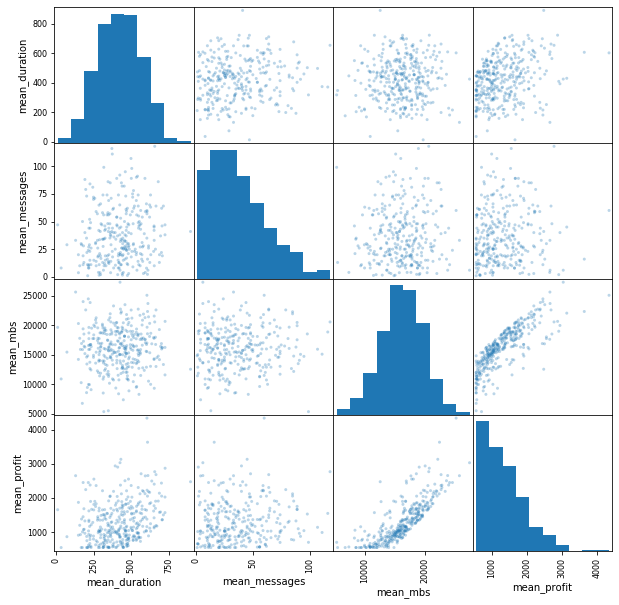

In [0]:
pd.plotting.scatter_matrix(smart[['mean_duration', 'mean_messages', 'mean_mbs', 'mean_profit']], alpha = 0.3, figsize = (10,10))

---
### Распределения - тариф "Смарт"
1. Кол-во минут - нормальное 
2. Кол-во сообщений - распределение Пуассона
3. Кол-во мегабайт - нормальное
---

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6312352588>,
      dtype=object)

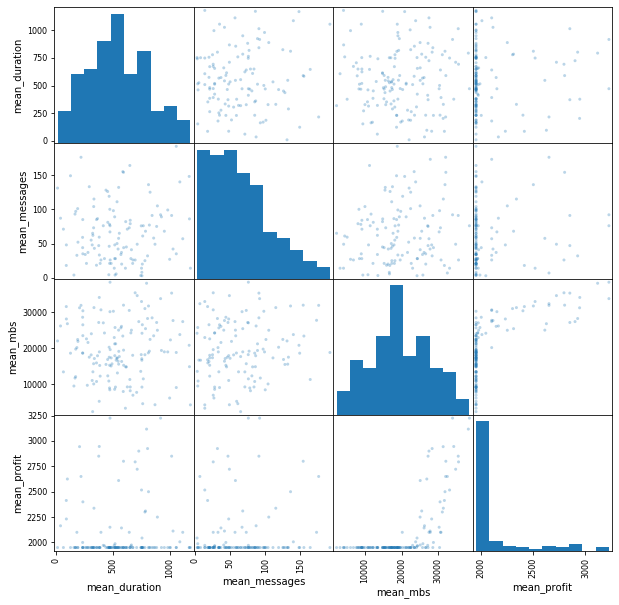

In [0]:
pd.plotting.scatter_matrix(ultra[['mean_duration', 'mean_messages', 'mean_mbs', 'mean_profit']], alpha = 0.3, figsize = (10,10))

---
### Распределения - тариф "Ультра"
1. Кол-во минут - нормальное 
2. Кол-во сообщений - распределение Пуассона
3. Кол-во мегабайт - нормальное
---

## Проверим гипотезы##
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

---
### Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Нулевой гипотезой будет гипотеза о том, что средние наших выборок равны.
Альтернативной гипотезой будет наша гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается".

Использую метод scipy.stats.ttest_ind (array1, array2, equal_var = False). False, потому что дисперсии наших выборок отличаются.

Критический уровень значимости задам 0.05. Хочу чтобы вероятность правильности моего вывода была 95% и больше.

In [0]:
from scipy import stats as st
alpha = 0.05
results = st.ttest_ind(smart['mean_profit'], ultra['mean_profit'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 7.582300754577309e-60
Отвергаем нулевую гипотезу


**Вывод по гипотезе 1:**

Нулевой гипотезой была гипотеза о равенстве средних наших выборок и очень маленькое p-value говорит нам о том, вероятность случайного совпадения средних наших выборок ничтожно мало. Нулевая гипотеза отвергается!

А значит сформулированная нами альтернативная гипотеза о том, что средние наших выборок отличаются, не отвергается!

---

### Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для проверки гипотезы создадим две соответствующие таблицы moscow и other. В обеих таблицах будут пользователи обоих тарифов, нужно проверить, чтобы их соотношение в обеих таблицах было примерно одинаково, иначе придётся проверять гипотезу не по 2, а по 4 выборкам - Москва - смарт, Москва - ультра, не Москва - смарт, не Москва - ультра.

Критический уровень значимости поставим 0.05. Хочу чтобы вероятность правильности моего вывода была 95% и больше.

Воспользуюсь методом scipy.stats.ttest_ind(array1, array2, equal_var = False). Equal_var будет False, так как мне кажется, что если считать дисперсию каждой выборки отдельно, то точность теста будет выше.

In [0]:
#создадим две таблицы, в одной будут все клиенты из москвы, во второй - все остальные
moscow = general_table[general_table['city'] == 'Москва']
other = general_table[general_table['city'] != 'Москва']

#проверим соотношения пользователей разных тарифов в наших выборках
moscow.pivot_table(index = 'tariff_id', values = 'mean_profit', aggfunc = 'count')
other.pivot_table(index = 'tariff_id', values = 'mean_profit', aggfunc = 'count')

alpha = 0.05
results = st.ttest_ind(moscow['mean_profit'], other['mean_profit'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.3540820152308114
Не получилось отвергнуть нулевую гипотезу


**Вывод по гипотезе 2:**

Соотношение в двух наших таблицах клиентов с разными тарифами примерно одинаковое, поэтому нам не пришлось создавать 4 таблицы.

Полученное нами p-value равно 0.35, а значит есть большая вероятность того, что отличие средних значений наших выборок случайно и мы не можем отвергнуть нулевую гипотезу, которая говорит нам о равенстве средних значений.

Значит, нашу альтернативную гипотезу о различии средних мы отвергаем!

---

## Общий вывод

Мы вывели из предоставленных нам таблиц все необходимые средние значения израсходованных минут, мегабайт и сообщений, **а также прибыль по ним по каждому месяцу** и посчитали по каждому из клиентов среднюю прибыль для компании. Далее мы разделили всех клиентов по тарифным группам и проверили правильность нашей гипотезы. 

Оказалось, действительно, средняя прибыльность в двух тарифах отличается, более того, мы заметили, что средние израсходованные кол-во звонков, кол-во сообщений и кол-во мегабайт интернет трафика не так сильно отличаются между тарифами, тогда как базовая стоимость тарифов отличается почти в 4 раза!

**Прибыль тарифа УЛЬТРА выше прибыли тарифа СМАРТ.**

В ходе реализации проекта мы столкнулись с некоторыми трудностями при расчётах, так как в наших данных присутствует необоснованно большое количество звонков и трафика, равные 0. Ввиду невозможности задать вопрос администратору клиентской базы о новой выгрузке или же о том, как такие значения получены, мы не стали искажать наши данные о клиентах и заменять нулевые значения любыми другими, так как есть вероятность того, что это не ошибка. При уточнении у администратора насчёт нулевых значений, мы в любой момент можем их заменить, дописав всего две строки кода.

---
<font color='blue'> Да, средние посчитаны верно, но надо посчитать длительность звонков за каждый месяц, иначе как рассчитавать затраты?. </font>

В прошлый раз длительности звонков за каждый месяц тоже были посчитаны, но прибыль я считал по средним значениям за год.

---
<font color='blue'> С интернетом аналогично. Надо знать каждый месяц, привысол пользователь лимит или нет, чтоб оценить, сколько он должен заплатить. </font>

Аналогично, в этот раз прибыль считал сначала по каждому месяцу и только потом вывел среднюю.

---
<font color='blue'> Нет, это не правильно. Как же ты сравниваешь среднее с лимитом? Если в первый месяц мы потратили 0, а во второй например 50 Гб интернета, то в среднем 25 Гб меньше лдимита в 30 Гб, и что мы не должны платить? Нет, за второй месяц мы заплатим за 20 Гб.... </font>

Посчитал теперь по каждому месяцу прибыль по всем ресурсам в отдельности, вывел средние по ним и только затем сложив их - общую среднюю прибыль. 

Если сложить средние прибыли по каждому из ресурсов за год с минимальной стоимостью тарифа - это будет равноценно тому, если мы посчитаем прибыль по всем ресурсам сразу вместе с минимальной стоимостью за каждый месяц и выведем среднюю за год.

---
<font color='blue'> Все чтло касается затрат ресурсов -это возможны вариант решения. Хотя и не оптимальный. Важно знать не только средние, но и превышение лимитов каждый месяц, количество месяцев с превышение лимитов и.т.д. </font>

<font color='blue'> А вот что каасается затрат, совсем не правильно. </font>

В этот раз посчитал и средние превышения лимитов на всякий случай.

---
<font color='blue'> Гипотезы естественно тоже не верны. Когда пересчитаешь выручку и перепроверишь гипотезы, не забудь поподробнее написать выводы. В выводах надо например указать, в каком тарифе выручка больше, а не просто что они различны. </font>

Пересчитал прибыль, она изменилась не очень сильно, решения по гипотезам не поменялись. В выводе указал что прибыль тарифа Ультра выше. 

---
<font color='blue'> Рассчеты выручки выполнены не правильно, пожалуйств, доработай. </font>

Доработал.

<font color='red'> Отлично, проект хорошо доработан. </font>

In [0]:
my_dict.keys()

dict_keys(['amount_of_minutes_by_month', 'amount_of_messages_by_month', 'amount_of_mbs_by_month', 'number_of_minutes_by_month', 'amount_by_month_func', 'add_tariff_id_func', 'add_tariffs_info_func', 'minutes_over_limit', 'messages_over_limit', 'mbs_over_limit', 'profit_per_minutes', 'profit_per_messages', 'profit_per_mbs', 'profit_func', 'add_mean_per_year_func', 'merger_func', 'general_table'])